In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv2
from ultralytics import YOLO
import pandas as pd
import imutils
import math

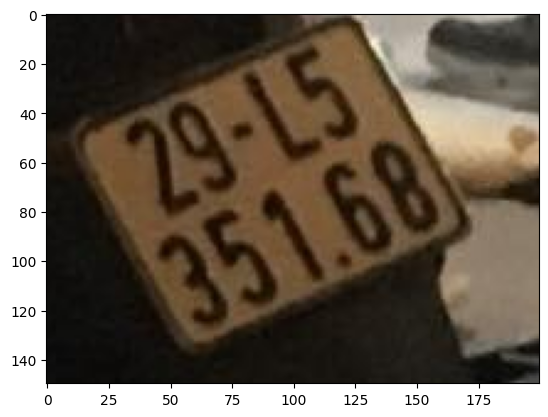

In [36]:
image = Image.open('./images/Motobike5.jpg')
image = np.array(image)
plt.imshow(image[700:850,580:780])
plt.show()

In [61]:
# save the image
plt.imsave('./images/saved_image.jpg', image[700:850,580:780])

In [3]:
def get_plate_bila(plate, sigma_color, sigma_space):
    screen = None
    try:
        plate_gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
        filtered = cv2.bilateralFilter(plate_gray, sigma_color, sigma_space, sigma_space)

        edged = cv2.Canny(filtered, 30, 200)
        edged = cv2.dilate(edged, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1)))
        contours = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)    

        cnts = imutils.grab_contours(contours)
        cnts = sorted(cnts, key= cv2.contourArea, reverse= True)[:10]

        

        for c in cnts:
            epsilon = 0.018*cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, epsilon, True)
            if len(approx) == 4:
                screen = approx
                break

        mask = np.zeros(plate_gray.shape, np.uint8)
    
    except:
        pass
    
    return screen

def get_plate_gaus(plate):
    screen = None
    try:
        plate_gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
        filtered = cv2.GaussianBlur(plate_gray, (5, 5), 0)

        edged = cv2.Canny(filtered, 30, 200)
        edged = cv2.dilate(edged, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1)))
        contours = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)    

        cnts = imutils.grab_contours(contours)
        cnts = sorted(cnts, key= cv2.contourArea, reverse= True)[:10]

        for c in cnts:
            epsilon = 0.018*cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, epsilon, True)
            if len(approx) == 4:
                screen = approx
                break

        mask = np.zeros(plate_gray.shape, np.uint8)
    
    except:
        pass
    
    return screen


0: 384x640 1 0, 17.0ms
Speed: 4.0ms preprocess, 17.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
[[[  8   6]]

 [[ 21  61]]

 [[251 128]]

 [[245  66]]]
(4, 1, 2)


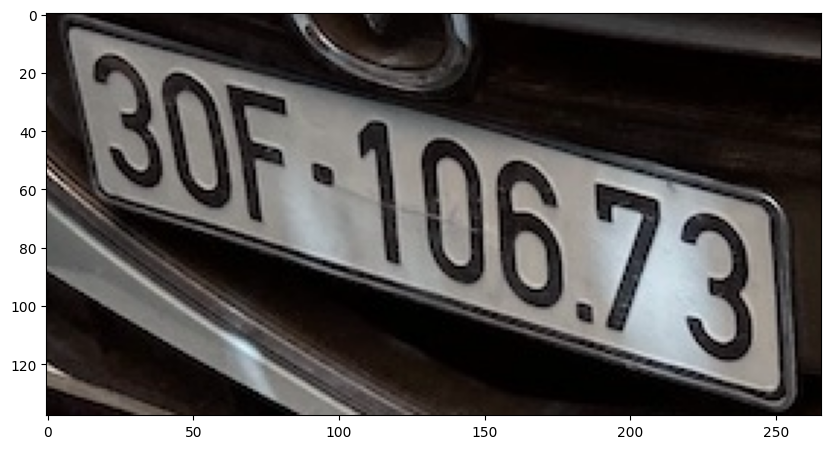

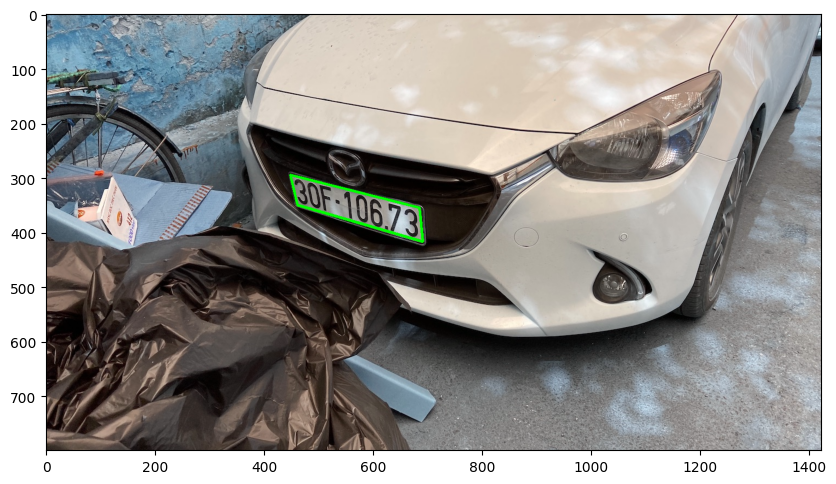

In [98]:
image = cv2.imread('./images/test.jpg')
# resize image to fit the model yolo v8

model = YOLO("./model/vn-robo/best.pt")

detections = model.predict(image)
a = detections[0].boxes.data
px = pd.DataFrame(a.cpu().numpy())
detections_ = []
for index, detection in px.iterrows():
    x1 = int(detection[0])
    y1 = int(detection[1])
    x2 = int(detection[2])
    y2 = int(detection[3])
    confidence = float(detection[4])
    class_id = int(detection[5])
    detections_.append([x1, y1, x2, y2])

    # cv2.circle(image, (x1, y1), 10, (255, 0, 0), -1)
    # cv2.circle(image, (x2, y2), 10, (255, 0, 0), -1)

if len(detections_) == 0:
    print("No plate detected")

for detection in detections_:
    (x3, y3, x4, y4) = detection

    # cv2.rectangle(image, (x3, y3), (x4, y4), (111, 111, 111), 3)

    roi_1 = image[int(y3):int(y4), int(x3):int(x4)]
    img = roi_1.copy()

    plt.figure(figsize=(10, 10))
    plt.imshow(roi_1)
    

    screen = get_plate_bila(roi_1, 5, 250)
    if screen is not None:
        cv2.drawContours(roi_1, [screen], -1, (0, 255, 0), 3)
        print(screen)
        print(screen.shape)
       
    else:
        screen = get_plate_gaus(roi_1)
        print(screen)
        if screen is not None:
            cv2.drawContours(roi_1, [screen], -1, (0, 255, 0), 3)
            print(screen)
        else:
            screen = get_plate_bila(roi_1, 13, 15)
            if screen is not None:
                cv2.drawContours(roi_1, [screen], -1, (0, 255, 0), 3)
                print(screen)
            else:
                print("No plate detected")

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [2]:
class HoughBundler:     
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle
    
    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])
      
        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []
  
        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)
                    
        return np.asarray(merged_lines_all)

In [3]:
def slope(x1,y1,x2,y2):
    ###finding slope
    if x2!=x1:
        return((y2-y1)/(x2-x1))
    else:
        return 'NA'

def drawLine(image,x1,y1,x2,y2):

    m=slope(x1,y1,x2,y2)
    h,w=image.shape[:2]
    if m!='NA':
        ### here we are essentially extending the line to x=0 and x=width
        ### and calculating the y associated with it
        ##starting point
        px=0
        py=-(x1-0)*m+y1
        ##ending point
        qx=w
        qy=-(x2-w)*m+y2
    else:
    ### if slope is zero, draw a line with x=x1 and y=0 and y=height
        px,py=x1,0
        qx,qy=x1,h
    cv2.line(image, (int(px), int(py)), (int(qx), int(qy)), (255, 255, 255), 1)

In [4]:
def rearrange_points(corners):
  # Find center
  center = [0]*2
  for i in range(corners.shape[0]):
    center[0] += corners[i][0][0]
    center[1] += corners[i][0][1]
  center[0] /= 4
  center[1] /= 4

  rearranged = [None]*4
  for i in range(4):
    if corners[i][0][0] < center[0] and corners[i][0][1] > center[1]:
      rearranged[i] = 0
    elif corners[i][0][0] > center[0] and corners[i][0][1] > center[1]:
      rearranged[i] = 1
    elif corners[i][0][0] > center[0] and corners[i][0][1] < center[1]:
      rearranged[i] = 2
    elif corners[i][0][0] < center[0] and corners[i][0][1] < center[1]:
      rearranged[i] = 3

  corners_copy = [None]*4
  for i in range(4):
    corners_copy[rearranged[i]] = [corners[i][0].tolist()]
  return corners_copy

[[[169  85]]

 [[ 58 134]]

 [[ 13  50]]

 [[126   2]]]


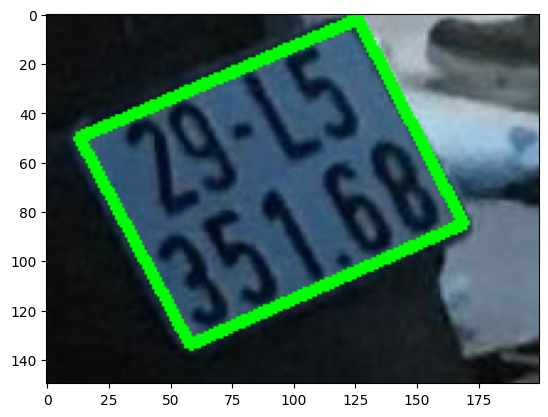

In [5]:
from utils.hough_plate import hough_plate

img = cv2.imread('./images/saved_image.jpg')

try:
  del corners
except:
  pass
corners = hough_plate(img)

cv2.drawContours(img, [corners], -1, (0, 255, 0), 3)

plt.imshow(img)
plt.show()

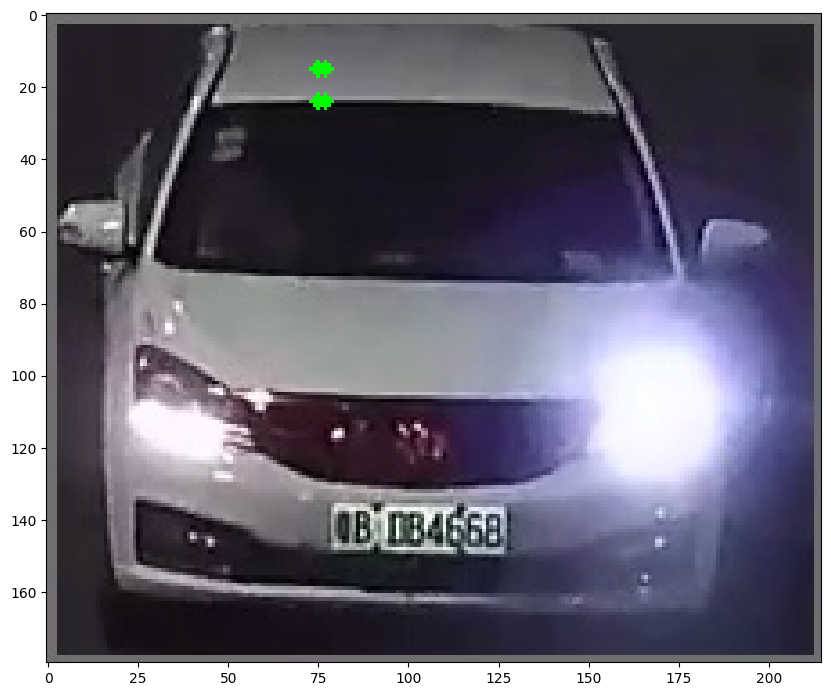

In [5]:
demo = np.zeros((4, 1, 2), dtype=np.int32)

demo[0][0][0] = 75
demo[0][0][1] = 15

demo[1][0][0] = 75
demo[1][0][1] = 24

demo[2][0][0] = 77
demo[2][0][1] = 24

demo[3][0][0] = 77
demo[3][0][1] = 15


image = cv2.imread('./images/roi_1.jpg')

cv2.drawContours(image, demo, -1, (0, 255, 0), 3)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()


0: 640x480 1 class_0, 18.0ms
Speed: 2.0ms preprocess, 18.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)
No edge detected


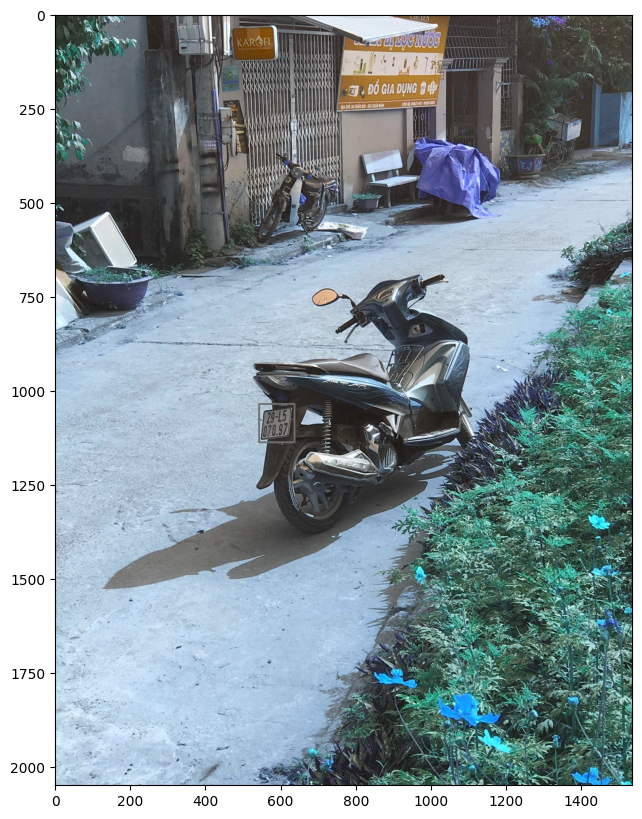

In [93]:
def detectPlates(image):
    image = image.copy()
    region = None
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        filtered = cv2.bilateralFilter(gray, 13, 15, 15)
        edged = cv2.Canny(filtered, 30, 200)

        contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key= cv2.contourArea, reverse= True)

        for c in contours:
            epsilon = 0.018*cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, epsilon, True)
            if len(approx) == 4:
                region = approx
                break
    except:
        print("No edge detected")
        
    return region

image = cv2.imread('./images/Motobike18.jpg')
# resize image to fit the model yolo v8

model = YOLO("./model/vn-kaggle/best.pt")
detections = model.predict(image)
a = detections[0].boxes.data
px = pd.DataFrame(a.cpu().numpy())
detections_ = []
for index, detection in px.iterrows():
    x1 = int(detection[0])
    y1 = int(detection[1])
    x2 = int(detection[2])
    y2 = int(detection[3])
    confidence = float(detection[4])
    class_id = int(detection[5])
    detections_.append([x1, y1, x2, y2])

if len(detections_) == 0:
    print("No plate detected")

for detection in detections_:
    (x1, y1, x2, y2) = detection

    cv2.rectangle(image, (x1, y1), (x2, y2), (111, 111, 111), 3)

    x1 = x1 - 20
    y1 = y1 - 20
    x2 = x2 + 20
    y2 = y2 + 20

    roi = image[y1:y2, x1:x2] 

    plate = detectPlates(roi)
    
    if plate is not None:
        cv2.drawContours(roi, [plate], -1, (0, 255, 0), 3)
    else: 
        print("No edge detected")

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()